In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Index(['cursor', 'timestamp', 'xpos', 'ypos', 'event', 'xpath', 'attrs',
       'extras', 'log_id', 'date', 'ua', 'screen', 'window', 'document',
       'task', 'user_id', 'ad_clicked', 'attention', 'x_diff', 'y_diff',
       'distance', 'speed', 'prev_timestamp', 'hover_time'],
      dtype='object')


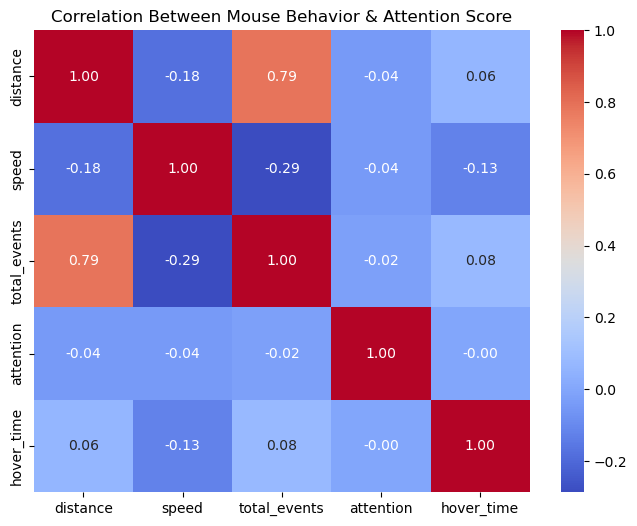

In [19]:
processed_dir = "processed/"

# Load all processed files
files = [os.path.join(processed_dir, f) for f in os.listdir(processed_dir) if f.endswith("_processed.csv")]

# Combine all processed CSVs
df_list = [pd.read_csv(file) for file in files]
df = pd.concat(df_list, ignore_index=True)

# Convert timestamp to seconds
df["timestamp"] = df["timestamp"] / 1000

# Compute movement metrics
df["x_diff"] = df["xpos"].diff().fillna(0)
df["y_diff"] = df["ypos"].diff().fillna(0)
df["distance"] = np.sqrt(df["x_diff"]**2 + df["y_diff"]**2)
df["speed"] = df["distance"] / df["timestamp"].diff().fillna(1)
df["prev_timestamp"] = df["timestamp"].shift(1)
df["hover_time"] = df["timestamp"] - df["prev_timestamp"]
df["hover_time"] = df["hover_time"].fillna(0)
print(df.columns)

# # Aggregate dwell time metrics per session
# session_stats["avg_hover_time"] = df.groupby("log_id")["hover_time"].mean()

# Aggregate movement features per session
session_stats = df.groupby("log_id").agg({
    "distance": "sum",
    "speed": "mean",
    "event": "count",
    "attention": "first",
    "hover_time": "mean",
    # "ad_clicked": "first"
}).rename(columns={"event": "total_events"})

# Compute correlation matrix
correlation_matrix = session_stats.corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Mouse Behavior & Attention Score")
plt.show()

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Prepare dataset for modeling
features = ["distance", "speed", "total_events", "hover_time"]
target = "ad_clicked"  # Predicting whether the user clicked on the ad (0 or 1)

# Drop rows with missing values
session_stats = session_stats.dropna(subset=[target])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    session_stats[features], session_stats[target], test_size=0.2, random_state=42
)

# Train a RandomForest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Display accuracy & classification report
print(f"Model Accuracy: {accuracy:.2f}")
print(report)


ValueError: Input X contains infinity or a value too large for dtype('float32').

In [17]:
X_train

,distance,speed,total_events,hover_time
log_id,,,,
20180820100236,9131.904069,8.277421e+03,29,1.641982e+06
20181002040148,6258.163238,6.903917e+03,38,1.329272e+06
20181002082405,3303.439173,inf,15,2.288518e+03
20170216033940,1322.258913,5.005923e+02,8,-6.397813e+06
20180118155639,2603.673285,1.253921e+04,35,7.262237e+05
...,...,...,...,...
20180126061326,3734.891432,2.174419e+04,23,-9.314950e+05
20170227164139,2606.601629,1.728719e+04,25,2.071740e+05
20170302141444,16315.985574,1.854632e+04,46,-4.289530e+04
